In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import time
import sys
import re
from PIL import Image
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

import torch
from torch import nn
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Compose


from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy
from mvn.models.pose_hrnet import get_pose_net as get_pose_hrnet
from mvn.models.pose_resnet import get_pose_net as get_pose_resnet

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import multiview
from mvn.utils import volumetric
from mvn.utils import op
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.datasets.human36m import Human36MMultiViewDataset, Human36MTemporalDataset
from mvn.utils.misc import get_start_stop_frame_indxs, index_to_name, get_error_diffs, normalize_temporal_images_batch, retval, get_capacity

from train import setup_human36m_dataloaders

from mvn.models.triangulation import VolumetricTriangulationNet
from mvn.models.volumetric_adain import VolumetricTemporalAdaINNet
from mvn.models.volumetric_grid import VolumetricTemporalGridDeformation
from mvn.models.volumetric_rnn_spade import VolumetricRNNSpade
from mvn.models.v2v import V2VModel, SPADE
from mvn.models.loss import KeypointsMSELoss, \
                            KeypointsMSESmoothLoss, \
                            KeypointsMAELoss, \
                            KeypointsL2Loss, \
                            VolumetricCELoss,\
                            GAN_loss,\
                            LSGAN_loss

from IPython.core.debugger import set_trace
from IPython.display import clear_output


%matplotlib inline

collate_fn = dataset_utils.make_collate_fn(randomize_n_views=False,
                                           min_n_views=None,
                                           max_n_views=None)

device = 'cuda:0' #torch.cuda.current_device()
print ('Done')
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True 

Done


In [2]:
def plot_stuff(metric_dicts, index):
    fig, axes = plt.subplots(ncols = 4, nrows=2, figsize=(20,7))
    for name, metric_dict in metric_dicts.items():
        axes[0,0].plot(metric_dict['total_loss'], alpha=0.5, label=name)
        axes[0,0].set_title('total_loss')

        axes[0,1].plot(metric_dict[f'{config.opt.criterion}'], alpha=0.5, label=name)
        axes[0,1].set_title('criterion loss')

        axes[0,2].plot(metric_dict['volumetric_ce_loss'], alpha=0.5, label=name)
        axes[0,2].set_title(f'volumetric_ce_loss: {config.opt.volumetric_ce_loss_weight}')
        
        axes[0,3].bar(height=metric_dict['time_weights'],x=range(aux_time), alpha=0.5, label=name)
        axes[0,3].set_title('time_weights')

        #####################################################

        axes[1,0].bar(x=range(aux_time),height=metric_dict['aux_criterion_distribution'], alpha=0.5)
        axes[1,0].set_title('aux_crit_distr')

        axes[1,1].plot(metric_dict['aux_criterion'], alpha=0.5, label=name)
        axes[1,1].set_title(f'aux_criterion: {style_pose_lstm_loss_weight} + timeweight')

        axes[1,2].plot(metric_dict['aux_lstm_VCE_loss'], alpha=0.5, label=name)
        axes[1,2].set_title(f'aux_lstm_VCE_loss: {aux_lstm_VCE_loss_weight * config.opt.volumetric_ce_loss_weight}')
        
        i = min(index, len(metric_dict['aux_criterion']))
        criterion_ = metric_dict[f'{config.opt.criterion}'][i]
        aux_criterion = metric_dict['aux_criterion'][i]
        vce = metric_dict['volumetric_ce_loss'][i]
        aux_vce = metric_dict['aux_lstm_VCE_loss'][i]
        axes[1,3].bar(height=[criterion_,vce, aux_criterion, aux_vce],
                      x=range(4), 
                      tick_label=['criterion',
                                   'vce', 
                                   'aux_criterion', 
                                   'aux_vce'], 
                      alpha=0.5, 
                      label=name)
        axes[1,3].set_title('total_loss components')
    plt.tight_layout()
    plt.show()

In [3]:
# experiment_type='spade_resnet_50/spade_rnn/'
# experiment_name='h36_sv32_dist_baseline_v2v-conf-vf64-lr1e-4_resnet50-gn_pf-lr1e-3_bs1-1_lr-1e-4_norot_gradclip-1e-2@23.06.2020-17:54:36'
# experiment_root = os.path.join('../logs/', experiment_type, experiment_name)
# config_path = experiment_root + '/config.yaml'

config_path = './experiments/human36m/train/human36m_vol_temporal_rnn_spade.yaml'

config = cfg.load_config(config_path)
config.dataset.val.retain_every_n_frames_in_test = 1

train_dataloader, val_loader, _ = setup_human36m_dataloaders(config,
                                                             is_train=True,
                                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.keypoints_per_frame if hasattr(config.dataset, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)


Batch size: 1 
 dt: 6 
 dilation: 1 
 pivot_type: first 
 pivot_position: -1 
 keypoints_per_frame True


# Model

In [4]:
model = {
    "vol": VolumetricTriangulationNet,
    "vol_temporal_adain":VolumetricTemporalAdaINNet,
    "vol_rnn_spade": VolumetricRNNSpade
}[config.model.name](config, device=device).to(device)

print ('Loaded {} model'.format(config.model.name))

rebuild_dict = config.model.rebuild_dict if hasattr(config.model, 'rebuild_dict') else False
state_dict = torch.load(config.model.checkpoint)['model_state']
if rebuild_dict:
    model_state_dict = model.state_dict() 
    for k,v in model_state_dict.items():
        if k in state_dict.keys():
            model_state_dict[k] = v
        else:
            assert 'adaptive_norm' or 'group_norm' in k
    state_dict = model_state_dict
    del model_state_dict 
model.load_state_dict(state_dict, strict=True)
del state_dict
torch.cuda.empty_cache()
print("LOADED PRE-TRAINED MODEL!!!")  

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone
Only resnet50 backbone is used...
backbone:  34.0M
volume_net:  52.19M
process_features:  0.02M
Loaded vol_rnn_spade model
LOADED PRE-TRAINED MODEL!!!


In [5]:
old_metric_dict = np.load('metric_dict_AVCE-1.0-C_ACRIT-1.0-timeweight.npy', allow_pickle=True).item()

# Train

IndexError: list index out of range

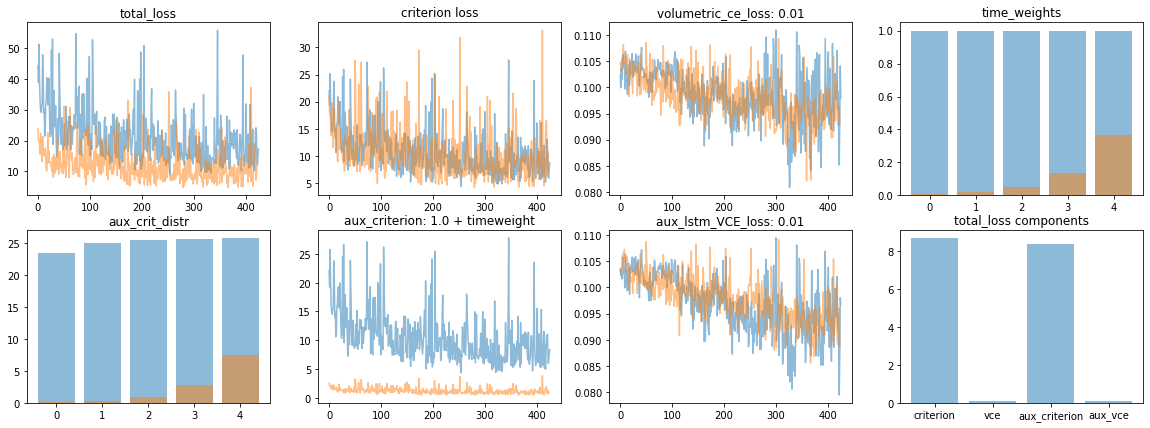

In [6]:
criterion = KeypointsMAELoss()
opt = torch.optim.Adam(
                [{'params': model.backbone.parameters()},
                 {'params': model.process_features.parameters(), \
                            'lr': config.opt.process_features_lr if \
                            hasattr(config.opt, "process_features_lr") else config.opt.lr},
                 {'params': model.volume_net.parameters(), \
                            'lr': config.opt.volume_net_lr if \
                            hasattr(config.opt, "volume_net_lr") else config.opt.lr}],
                lr=config.opt.lr)
dataloader = train_dataloader
n_iters_total=0
is_train=True
caption=''
master=False
experiment_dir=None
writer=None
discriminator=None
opt_discr=None
epoch = 0

name = "train" if is_train else "val"
model_type = config.model.name
silence = config.opt.silence if hasattr(config.opt, 'silence') else False

singleview_dataset = config.dataset.singleview if hasattr(config.dataset, 'singleview') else False
pivot_type = config.dataset.pivot_type
pivot_index =  {'first':config.dataset.dt-1,
                'intermediate':config.dataset.dt//2}[pivot_type]

visualize_volumes = config.visualize_volumes if hasattr(config, 'visualize_volumes') else False
visualize_heatmaps = config.visualize_heatmaps if hasattr(config, 'visualize_heatmaps') else False
visualize = config.visualize if hasattr(config, "visualize") else True

scale_keypoints_3d = config.opt.scale_keypoints_3d if hasattr(config.opt, "scale_keypoints_3d") else 1.0    
transfer_cmu_to_human36m = config.transfer_cmu_to_human36m if hasattr(config, "transfer_cmu_to_human36m") else False
use_temporal_discriminator = config.opt.use_temporal_discriminator if hasattr(config.opt, "use_temporal_discriminator") else False
use_bone_length_term = config.opt.use_bone_length_term if hasattr(config.opt, 'use_bone_length_term') else False
bone_length_weight = config.opt.bone_length_weight if hasattr(config.opt, 'bone_length_weight') else None
keypoints_per_frame = config.dataset.keypoints_per_frame if hasattr(config.dataset, 'keypoints_per_frame') else False

lstm_output = config.model.name in ['vol_temporal_lstm', 'vol_rnn_spade']

use_style_decoder = config.model.use_style_decoder if hasattr(config.model, 'use_style_decoder') else False
decoder_loss_with_next_features = config.model.decoder_loss_with_next_features if hasattr(config.model, 'decoder_loss_with_next_features') else True
use_time_weighted_loss = config.opt.use_time_weighted_loss if hasattr(config.opt, 'use_time_weighted_loss') else False
use_style_pose_lstm_loss = config.model.use_style_pose_lstm_loss if hasattr(config.model, 'use_style_pose_lstm_loss') else False

if use_style_pose_lstm_loss or lstm_output:
    style_pose_lstm_loss_weight = config.opt.style_pose_lstm_loss_weight if hasattr(config.opt, 'style_pose_lstm_loss_weight') else 1.
    aux_lstm_VCE_loss_weight = config.opt.aux_lstm_VCE_loss_weight if hasattr(config.opt, 'aux_lstm_VCE_loss_weight') else 1.

if use_temporal_discriminator:
    assert (discriminator is not None) and (opt_discr is not None)
    adversarial_temporal_criterion = {'vanilla':GAN_loss(),
                                      'lsgan':LSGAN_loss()}[config.opt.adversarial_temporal_criterion]
    adversarial_temporal_loss_weight = config.opt.adversarial_temporal_loss_weight
    adversarial_generator_iters = config.opt.adversarial_generator_iters 
    train_generator_during_critic_iters = config.opt.train_generator_during_critic_iters                               

use_style_pose_vce_loss = config.opt.use_style_pose_vce_loss if hasattr(config.opt, 'use_style_pose_vce_loss') else False
use_style_pose_criterion_loss = config.opt.use_style_pose_criterion_loss if hasattr(config.opt, 'use_style_pose_criterion_loss') else False
style_vce_weight = config.opt.style_vce_weight if use_style_pose_vce_loss else None
style_criterion_weight = config.opt.style_criterion_weight if use_style_pose_criterion_loss else None

if is_train:
    model.train()
else:
    model.eval()

metric_dict = defaultdict(list)
results = defaultdict(list)

# used to turn on/off gradients
grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
with grad_context():

    iterator = enumerate(dataloader)
    if is_train and config.opt.n_objects_per_epoch is not None:
        iterator = islice(iterator, config.opt.n_objects_per_epoch)

    for iter_i, batch in tqdm_notebook(iterator):
        with autograd.detect_anomaly():
            if batch is None:
                print("Found None batch at iter {}, continue...".format(iter_i))
                continue 

            debug = False    
            (images_batch, 
            keypoints_3d_gt, 
            keypoints_3d_validity_gt, 
            proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)

            heatmaps_pred, keypoints_2d_pred, cuboids_pred, base_points_pred = None, None, None, None
            torch.cuda.empty_cache()
            if config.model.name == 'vol_temporal_grid':
                (keypoints_3d_pred, 
                features_pred, 
                volumes_pred, 
                confidences_pred, 
                cuboids_pred, 
                coord_volumes_pred, 
                base_points_pred,
                coord_offsets) = model(images_batch, batch)

            elif config.model.name == 'vol_temporal_adain':    
                (keypoints_3d_pred, 
                features_pred, 
                volumes_pred, 
                confidences_pred, 
                cuboids_pred, 
                coord_volumes_pred, 
                base_points_pred,
                style_vector,
                unproj_features,
                decoded_features) = model(images_batch, batch, debug=debug, master=master) 

            else:    
                (keypoints_3d_pred, 
                features_pred, 
                volumes_pred, 
                confidences_pred, 
                cuboids_pred, 
                coord_volumes_pred,
                base_points_pred) = model(images_batch, batch)            

            batch_size, dt = images_batch.shape[:2]
            keypoints_3d_binary_validity_gt = (keypoints_3d_validity_gt > 0.0).type(torch.float32)
            keypoints_shape = keypoints_3d_gt.shape[-2:]
            ################
            # MODEL OUTPUT #   
            ################
            if use_style_pose_lstm_loss:
                assert keypoints_per_frame and isinstance(keypoints_3d_pred, list)

                auxilary_keypoints_3d_gt = keypoints_3d_gt[:,pivot_index+1:].contiguous()
                auxilary_keypoints_3d_pred = keypoints_3d_pred[1].contiguous()
                auxilary_keypoints_3d_binary_validity_gt = keypoints_3d_binary_validity_gt[:,pivot_index+1:].contiguous()

                keypoints_3d_gt = keypoints_3d_gt[:,pivot_index]
                keypoints_3d_pred = keypoints_3d_pred[0]
                keypoints_3d_binary_validity_gt = keypoints_3d_binary_validity_gt[:,pivot_index]

            # [X_t-dt,...,X_t]    
            if lstm_output:
                assert keypoints_per_frame

                auxilary_keypoints_3d_gt = keypoints_3d_gt[:,:pivot_index].contiguous()
                auxilary_keypoints_3d_pred =  keypoints_3d_pred[:,:pivot_index]
                auxilary_keypoints_3d_binary_validity_gt = keypoints_3d_binary_validity_gt[:,:pivot_index].contiguous()

                keypoints_3d_gt = keypoints_3d_gt[:,pivot_index]
                keypoints_3d_pred = keypoints_3d_pred[:,pivot_index]
                keypoints_3d_binary_validity_gt = keypoints_3d_binary_validity_gt[:,pivot_index]

            if singleview_dataset:
                coord_volumes_pred = coord_volumes_pred - base_points_pred.unsqueeze(1).unsqueeze(1).unsqueeze(1)
                keypoints_3d_gt = op.root_centering(keypoints_3d_gt, config.kind)
                keypoints_3d_pred = op.root_centering(keypoints_3d_pred, config.kind)
                if use_style_pose_lstm_loss or lstm_output:

                    # need to extract aux. volumes for temporal weighted VCE loss
                    if lstm_output:
                        coord_volumes_pred = coord_volumes_pred.view(batch_size, dt, *coord_volumes_pred.shape[-4:])
                        volumes_pred = volumes_pred.view(batch_size, dt, *volumes_pred.shape[-4:])

                        aux_coord_volumes_pred = coord_volumes_pred[:,:pivot_index].contiguous()
                        aux_volumes_pred = volumes_pred[:,:pivot_index].contiguous()

                        coord_volumes_pred = coord_volumes_pred[:,pivot_index]
                        volumes_pred = volumes_pred[:,pivot_index]


                    auxilary_keypoints_3d_gt = op.root_centering(auxilary_keypoints_3d_gt.view(-1, *keypoints_shape),
                                                                 config.kind)
                    auxilary_keypoints_3d_pred = op.root_centering(auxilary_keypoints_3d_pred.view(-1, *keypoints_shape), 
                                                                   config.kind)
                    auxilary_keypoints_3d_gt = auxilary_keypoints_3d_gt.view(batch_size, -1, *keypoints_shape)
                    auxilary_keypoints_3d_pred = auxilary_keypoints_3d_pred.view(batch_size, -1, *keypoints_shape)

            ##################
            # CALCULATE LOSS #   
            ##################
            # MSE\MAE loss
            total_loss = 0.0
            loss = criterion((keypoints_3d_pred  - keypoints_3d_gt)*scale_keypoints_3d,keypoints_3d_binary_validity_gt)
            total_loss += loss
            metric_dict[f'{config.opt.criterion}'].append(loss.item())

            # lstm temporal pose-style loss
            if use_style_pose_lstm_loss or lstm_output:
                aux_time = auxilary_keypoints_3d_gt.shape[1]
                if use_time_weighted_loss: 
                    if use_style_pose_lstm_loss:
                        future_keypoints_loss_weight = torch.stack([torch.exp(torch.arange(0,(-dt//2)+1, -1, dtype=torch.float)) \
                                                                for i in range(batch_size)]).view(batch_size, -1,1,1).to(device)
                    elif lstm_output: 
                        future_keypoints_loss_weight = torch.stack([torch.exp(torch.arange((-dt)+1,0, 1, dtype=torch.float)) \
                                                                for i in range(batch_size)]).view(batch_size, -1,1,1).to(device)
                    else:
                        raise RuntimeError('Unrecognized type of `time_weighted_loss` usage')    
                else:
                    future_keypoints_loss_weight = torch.ones((batch_size, aux_time,1,1)).to(device)

                # check auxilary_keypoints_3d_pred grad_fn
                pose_lstm_diff = (auxilary_keypoints_3d_gt - auxilary_keypoints_3d_pred)*scale_keypoints_3d*future_keypoints_loss_weight
                validity = auxilary_keypoints_3d_binary_validity_gt.view(-1, *auxilary_keypoints_3d_binary_validity_gt.shape[-2:])
                pose_lstm_loss = criterion(pose_lstm_diff.view(-1, *pose_lstm_diff.shape[-2:]), validity)
                weighted_style_pose_lstm_loss = style_pose_lstm_loss_weight * pose_lstm_loss
                total_loss += weighted_style_pose_lstm_loss
                metric_dict['aux_criterion'].append(weighted_style_pose_lstm_loss.item())
                batch_index = 0
                time_weights = future_keypoints_loss_weight[batch_index].flatten().detach().cpu().numpy()
                aux_criterion_distribution = torch.abs(pose_lstm_diff[batch_index]).sum(-1).mean(-1).detach().cpu().numpy() * style_pose_lstm_loss_weight
                
                metric_dict['time_weights'] = time_weights
                metric_dict['aux_criterion_distribution'] = aux_criterion_distribution

            # volumetric loss
            use_volumetric_ce_loss = config.opt.use_volumetric_ce_loss
            if use_volumetric_ce_loss:
                volumetric_ce_criterion = VolumetricCELoss()
                loss = volumetric_ce_criterion(coord_volumes_pred, 
                                                volumes_pred, 
                                                keypoints_3d_gt, 
                                                keypoints_3d_binary_validity_gt)
                weight = config.opt.volumetric_ce_loss_weight
                total_loss += weight * loss
                metric_dict['volumetric_ce_loss'].append(weight*loss.item())

                if lstm_output:
                    # pass squeezed tensors
                    loss = volumetric_ce_criterion(aux_coord_volumes_pred.view(-1, *aux_coord_volumes_pred.shape[2:]), 
                                                    aux_volumes_pred.view(-1, *aux_volumes_pred.shape[2:]), 
                                                    auxilary_keypoints_3d_gt.view(-1, *auxilary_keypoints_3d_gt.shape[2:]), 
                                                    auxilary_keypoints_3d_binary_validity_gt.view(-1, *auxilary_keypoints_3d_binary_validity_gt.shape[2:]))
                    weight = config.opt.volumetric_ce_loss_weight
                    total_loss += aux_lstm_VCE_loss_weight * weight * loss
                    metric_dict['aux_lstm_VCE_loss'].append(aux_lstm_VCE_loss_weight*weight*loss.item())    

            ############
            # BACKWARD #   
            ############
            if use_temporal_discriminator:
                adversarial_condition =  (train_generator_during_critic_iters or iter_i%adversarial_generator_iters == 0)
            else:
                adversarial_condition=True    
            if is_train and adversarial_condition:
                opt.zero_grad()
                total_loss.backward()        

                if hasattr(config.opt, "grad_clip"):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.opt.grad_clip / config.opt.lr)

                metric_dict['grad_norm_times_lr'].append(config.opt.lr * \
                                                         misc.calc_gradient_norm(filter(lambda x: x[1].requires_grad, \
                                                         model.named_parameters()), silence=silence))
                metric_dict['grad_amplitude_times_lr'].append(config.opt.lr * \
                                                              misc.calc_gradient_magnitude(filter(lambda x: x[1].requires_grad, \
                                                              model.named_parameters()), silence=silence))

                opt.step()
            metric_dict['total_loss'].append(total_loss.item())
            
            ########
            # PLOT #
            ########
            if iter_i%5 == 0:
                clear_output()
                plot_stuff({'new':metric_dict, 'original':old_metric_dict}, iter_i)
            
            

In [ ]:
# np.save(f'metric_dict_AVCE-{aux_lstm_VCE_loss_weight}-C_ACRIT-{style_pose_lstm_loss_weight}-timeweight', metric_dict)